In [35]:
from __future__ import division
import os
from tqdm import tqdm
from natsort import natsorted
import nibabel as nb
import statistics
# Opens data file and constructs features
def get_data(subdir):
    data = pd.DataFrame(columns=['mean', 'median', 'stdev'])
    for filename in tqdm(natsorted(os.listdir(subdir))):
        path = subdir + filename
        img = nb.load(path).get_data()[..., 0]
        hist = img[img > 0].flatten()
        data = data.append({'mean': hist.mean(),
                            'median': statistics.median(hist),
                            'stdev': statistics.stdev(hist),
                           }, ignore_index=True)
    return data

In [56]:
# Fetch data or open files with data
import pandas as pd
train_features = pd.DataFrame.from_csv('../data/train_data.csv')[["mean", "median", "stdev", "gm", "age"]]
test_features = pd.DataFrame.from_csv('../data/test_data.csv')[["mean", "median", "stdev", "gm"]]

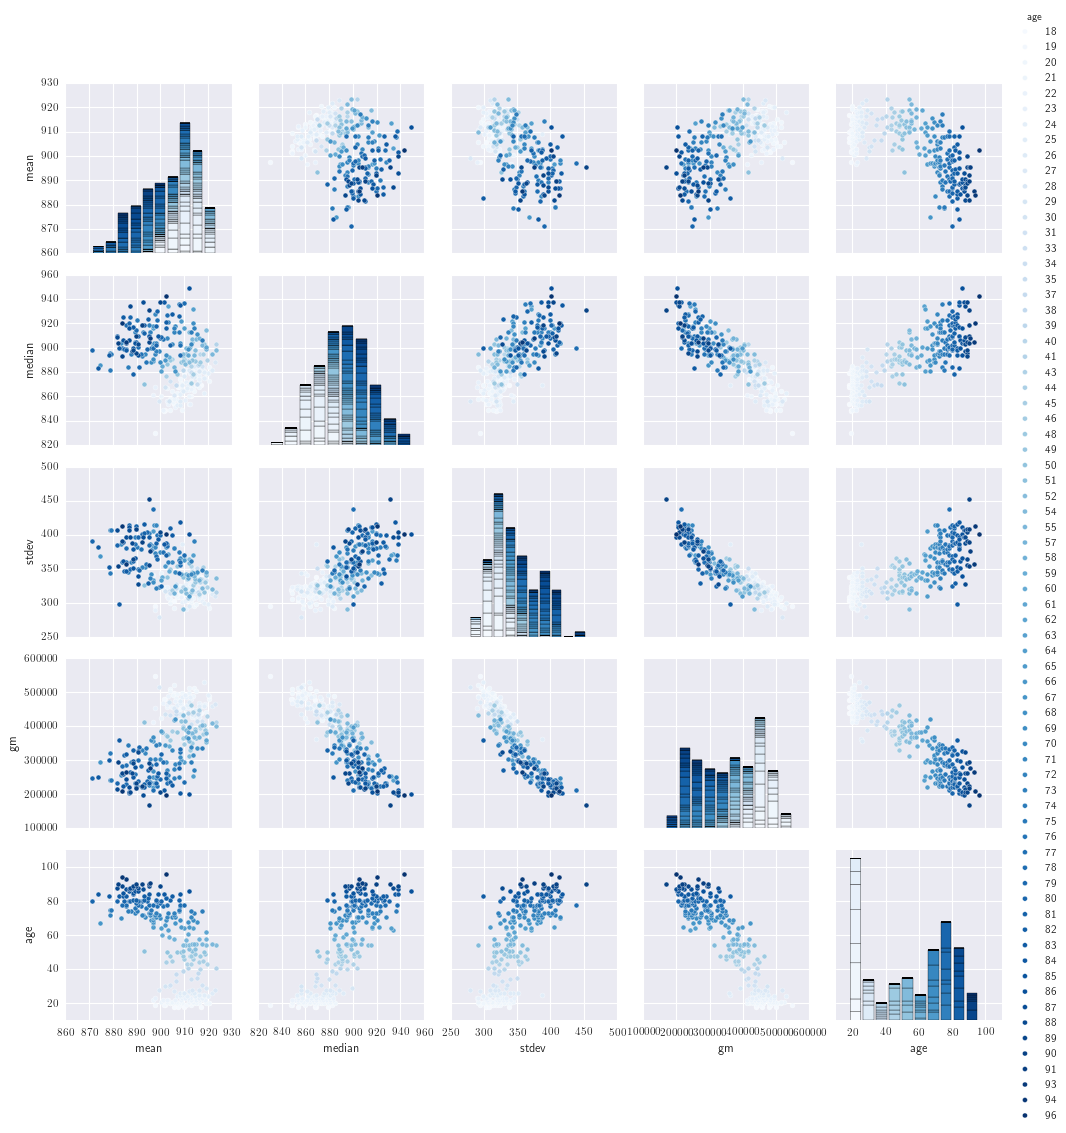

In [47]:
# Show pairwise relations between features
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.pairplot(train_features, hue='age', palette='Blues')

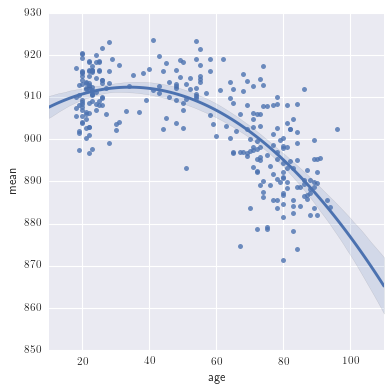

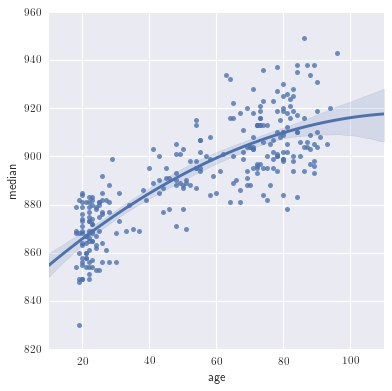

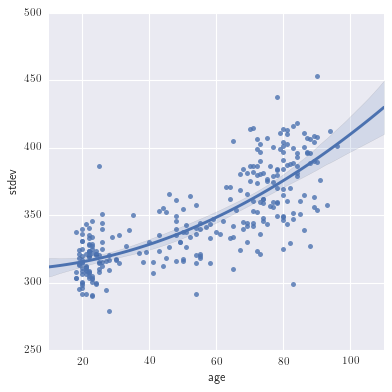

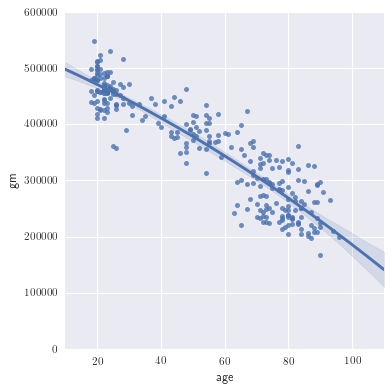

In [48]:
# Illustrate polynomial regression features vs. age
order = 2
sb.lmplot(y='mean', x='age', data=train_features, order=order)
sb.lmplot(y='median', x='age', data=train_features, order=order)
sb.lmplot(y='stdev', x='age', data=train_features, order=order)
sb.lmplot(y='gm', x='age', data=train_features, order=order)

In [64]:
#from sklearn.cross_validation import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
alpha = 40
order = 2
best_estimator_name, best_estimator, best_order, min_error = '', None, 0, 1000
# Train and test model
X = train_features.drop("age", axis=1).as_matrix()
y = train_features["age"].as_matrix()
kf = KFold(n_splits=5)
train_test_split = list(kf.split(X))
normalize = False
for order in range(1, 6):
    for alpha in range(50, 2001, 50):
        estimators = [
            ('LinearRegression', LinearRegression(normalize=normalize)),
            ('Ridge(alpha=%d)' % (alpha), Ridge(alpha=alpha, normalize=normalize)),
            ('Lasso(alpha=%d)' % (alpha), Lasso(alpha=alpha, normalize=normalize))
        ]
        for estimator_name, estimator in estimators:
            model = make_pipeline(PolynomialFeatures(order), estimator)
            errors = []
            for train, test in train_test_split:
                X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
                model.fit(X_train, y_train)                    
                predictions = model.predict(X_test)
                errors.append(mean_squared_error(y_test, predictions))
            errors_mean = sum(errors) / len(errors)
            print '%s [%d]: %f' % (estimator_name, order, errors_mean)
            if min_error > errors_mean:
                best_estimator_name = estimator_name
                best_estimator = estimator
                min_error = errors_mean
                best_order = order
            
print "\nBest result:"
print best_estimator_name, best_order, min_error

LinearRegression [1]: 78.340148
Ridge(alpha=50) [1]: 78.306196
Lasso(alpha=50) [1]: 97.834768
LinearRegression [1]: 78.340148
Ridge(alpha=100) [1]: 78.274123
Lasso(alpha=100) [1]: 105.530354
LinearRegression [1]: 78.340148
Ridge(alpha=150) [1]: 78.243804
Lasso(alpha=150) [1]: 105.530337
LinearRegression [1]: 78.340148
Ridge(alpha=200) [1]: 78.215127
Lasso(alpha=200) [1]: 105.530319
LinearRegression [1]: 78.340148
Ridge(alpha=250) [1]: 78.187989
Lasso(alpha=250) [1]: 105.530303
LinearRegression [1]: 78.340148
Ridge(alpha=300) [1]: 78.162295
Lasso(alpha=300) [1]: 105.530286
LinearRegression [1]: 78.340148
Ridge(alpha=350) [1]: 78.137960
Lasso(alpha=350) [1]: 105.530271
LinearRegression [1]: 78.340148
Ridge(alpha=400) [1]: 78.114904
Lasso(alpha=400) [1]: 105.530256
LinearRegression [1]: 78.340148
Ridge(alpha=450) [1]: 78.093053
Lasso(alpha=450) [1]: 105.530241
LinearRegression [1]: 78.340148
Ridge(alpha=500) [1]: 78.072342
Lasso(alpha=500) [1]: 105.530228
LinearRegression [1]: 78.340148
R

In [65]:
best_order = 2
best_estimator = LinearRegression()
best_model = make_pipeline(PolynomialFeatures(best_order), best_estimator)
best_model.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [66]:
predictions = best_model.predict(test_features)
predictions = [min(max(int(round(i)), 18), 96) for i in predictions]
result = pd.DataFrame({'ID': range(1, len(predictions)+1), 'Prediction': predictions})
print ''
result.to_csv('../data/result_%s-order-%d.csv' % (best_estimator_name, best_order), index=False)

In [67]:
print predictions

[57, 52, 48, 45, 95, 29, 39, 81, 30, 24, 56, 63, 31, 35, 18, 70, 82, 34, 79, 71, 40, 29, 20, 37, 22, 38, 42, 67, 38, 30, 51, 32, 59, 84, 18, 41, 19, 22, 18, 18, 91, 83, 70, 43, 33, 65, 26, 71, 86, 61, 84, 84, 31, 66, 85, 70, 49, 73, 18, 29, 74, 33, 70, 43, 18, 26, 23, 67, 80, 84, 63, 60, 84, 43, 69, 78, 30, 64, 56, 42, 33, 29, 79, 67, 23, 80, 18, 50, 28, 82, 73, 72, 18, 73, 61, 68, 77, 43, 58, 18, 32, 25, 26, 77, 72, 76, 81, 78, 18, 18, 75, 70, 48, 58, 58, 55, 33, 65, 85, 80, 37, 35, 79, 18, 47, 29, 57, 76, 26, 66, 44, 26, 65, 78, 67, 75, 59, 63]
